want to try and optimize feature selection

from what i can see, accident, vehicle, and person datasets seem the most relevant, might try to take some features from there

converting each csv into a dataframe for better handling
- df is our base df, will be writing it to a new csv when done
- finding intersection btwn all three csvs, using that to drop features from df1 and df2.
- i then will be adding df1 and df2 (with only unique cols) into df
- from here, determine features with strongest correlation to target since our max is 20 features
- going to run decision tree model from demo.ipynb on new csv to see if any improvements in accuracy

In [1]:
import os
import pandas as pd 
import numpy as np 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
RANDOM_STATE = 42

"""df = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\accident23.csv")
df1 = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\vehicle23.csv")
df2 = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\person23.csv")

df3 = pd.DataFrame()"""

'df = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\accident23.csv")\ndf1 = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\vehicle23.csv")\ndf2 = pd.read_csv("C:\\Users\\15013\\Desktop\\CRSS2023CSV\\person23.csv")\n\ndf3 = pd.DataFrame()'

In [3]:
#checking for missing/unknown values and changing to NaN
#most of the code taken from demo.ipynb

#tentative colnames from each csv
acc_cols = [
    "CASENUM",
    "MONTH",
    "DAY_WEEK",
    "HOUR",
    "WEATHER",
    "LGT_COND",
    "HARM_EV", #first harmful event that took place
    "MAN_COLL", #the kind of collision
    "REL_ROAD",
    "TYP_INT",
    "URBANICITY",#was the area urban or rural
    "MAX_SEV" 
]

veh_cols = [
    "CASENUM",
    "VSPD_LIM", #speed limit of the area
    "VSURCOND",
    "ACC_TYPE", #type of accident
    "SPEEDREL", #was accident speeding related
    "DEFORMED" #extent of damage
]

person_cols = [
    "CASENUM",
    "AGE",
    "SEX",
    "PER_TYP", #role of the person at time of crash i.e. driver, occupant, etc
    "SEAT_POS", #where in car person was sitting
    "REST_USE" #restraint system used i.e. seatbelt, motorcycle helmet, etc
]

#went through the manual, found what values represent NaN for each colname
UNKNOWN_MAP = {
    #accident csv
    "DAY_WEEK": {9},
    "HOUR": {99},
    "HARM_EV": {99},
    "MAN_COLL": {99, 98},
    "TYP_INT": {99, 98},
    "REL_ROAD": {99, 98},
    "LGT_COND": {9, 8},
    "WEATHER": {98, 99},
    
    #vehicle csv
    "VSPD_LIM": {98, 99},
    "VSURCOND": {99},
    "ACC_TYPE": {5, 10, 16, 33, 43, 49, 53, 63, 67, 75, 85, 91, 99},
    "SPEEDREL": {8, 9},
    "DEFORMED": {8,9},
    
    #person csv
    "AGE": {998, 999},
    "SEX": {8, 9},
    "PER_TYP": {9,  19},
    "SEAT_POS": {98, 99},
    "REST_USE": {98, 99}
}


In [7]:
#feed 3 csvs into combine, feed combine() into clean_nan, feed clean_nan() into imp

def combine(acc, per, veh):
    enc = "cp1252"
    #take in accident, person, vehicle csvs for a year, join them together
    #using the defined columns in prev cell, then use pd.merge
    acc_df = pd.read_csv(acc, encoding= enc)[acc_cols]
    per_df = pd.read_csv(per, encoding = enc)[person_cols]
    veh_df = pd.read_csv(veh, encoding = enc )[veh_cols]
    
    #first record per case, when i didnt do this each df had like 500k entries
    acc_first = acc_df.groupby("CASENUM").head(1)
    per_first = per_df.groupby("CASENUM").head(1)
    veh_first = veh_df.groupby("CASENUM").head(1)

    final = ( #merge the frames based on case number
        acc_first
        .merge(per_first, on="CASENUM", how="left")
        .merge(veh_first, on="CASENUM", how="left")
    )
    final = final[final['MAX_SEV'] <= 4] #drop where sev vals > 4

    return final
    

def clean_nan(frame):
    df_clean = frame.copy()

    rows = []
    n = len(df_clean)

    # convert all "unknown codes" to NaN using the map
    for col, codes in UNKNOWN_MAP.items():
        if len(codes) > 0 and col in df_clean.columns:
            df_clean.loc[df_clean[col].isin(codes), col] = np.nan

        unk_count = df_clean[col].isna().sum() if codes else 0

        rows.append({
            "column": col,
            "unknown_codes": sorted(codes),
            "unknown_count": int(unk_count),
            "unknown_percent": round(100 * unk_count / n, 3) if n else 0.0
        })

    #unknown_summary = pd.DataFrame(rows).sort_values("unknown_percent", ascending=False)
    #print(unknown_summary)

    return df_clean


#drop rows where NaN vals > 50% of the row
#for remaining rows, impute missing NaN vals

def imp(frame):
    min_non_na = int(0.7 * len(frame.columns))
    df_drop = frame.dropna(thresh=min_non_na)

    imputer = SimpleImputer(strategy="median")
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_drop),
        columns=df_drop.columns
    )
    
    return df_imputed

workspace = "C:\\Users\\15013\\Desktop\\acc_per_veh\\"
files = [["accident16.CSV",'person16.CSV','vehicle16.CSV'], ["accident17.CSV",'person17.CSV','vehicle17.CSV'], ["accident18.csv",'person18.csv','vehicle18.csv'], ["accident19.CSV",'person19.CSV','vehicle19.csv'], 
        ["accident20.csv",'person20.csv','vehicle20.csv'], ["accident21.csv",'person21.csv','vehicle21.csv'], ["accident22.csv",'person22.csv','vehicle22.csv'], ["accident23.csv",'person23.csv','vehicle23.csv']]

final = pd.DataFrame()
for f in files:
    d1 = combine(workspace+f[0], workspace+f[1], workspace+f[2])
    d2 = clean_nan(d1)
    d3 = imp(d2)
    final = pd.concat([final, d3], ignore_index=True)

final.to_csv('output.csv')

C:\Users\15013\AppData\Local\Temp\ipykernel_13000\1413745174.py:9: DtypeWarning: Columns (23,24,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  veh_df = pd.read_csv(veh, encoding = enc )[veh_cols]
C:\Users\15013\AppData\Local\Temp\ipykernel_13000\1413745174.py:9: DtypeWarning: Columns (26,27,74) have mixed types. Specify dtype option on import or set low_memory=False.
  veh_df = pd.read_csv(veh, encoding = enc )[veh_cols]
C:\Users\15013\AppData\Local\Temp\ipykernel_13000\1413745174.py:9: DtypeWarning: Columns (26,27,74) have mixed types. Specify dtype option on import or set low_memory=False.
  veh_df = pd.read_csv(veh, encoding = enc )[veh_cols]
C:\Users\15013\AppData\Local\Temp\ipykernel_13000\1413745174.py:7: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_df = pd.read_csv(acc, encoding= enc)[acc_cols]
C:\Users\15013\AppData\Local\Temp\ipykernel_13000\1413745174.py:9: DtypeWarning: Columns 

Decision Tree Accuracy: 0.5439189741076533
              precision    recall  f1-score   support

         0.0       0.63      0.88      0.74     59042
         1.0       0.34      0.21      0.26     27519
         2.0       0.39      0.27      0.32     20104
         3.0       0.35      0.22      0.27     13152
         4.0       0.37      0.11      0.17      2613

    accuracy                           0.54    122430
   macro avg       0.42      0.34      0.35    122430
weighted avg       0.49      0.54      0.50    122430



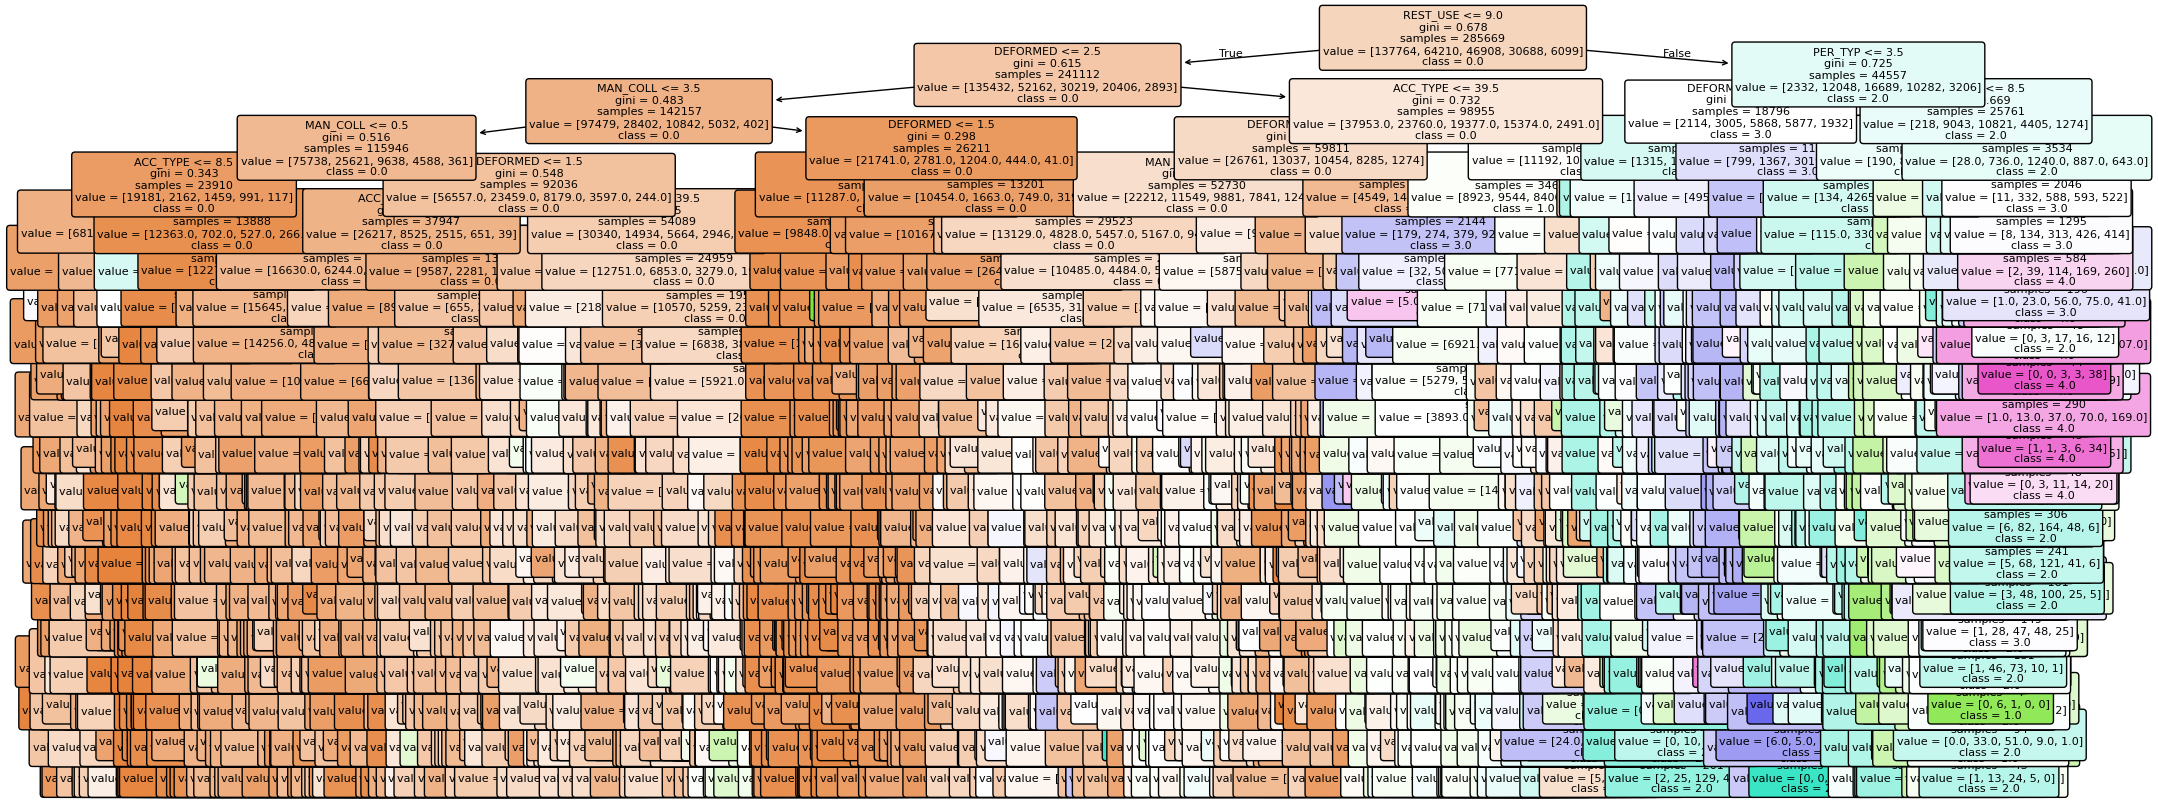

In [9]:
#starting on the model
#final accuracy around 54% for only one year of data, around 49000 points
#hopefully would improve further with full dataset
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

X = final.drop(columns=['MAX_SEV'])
y = final['MAX_SEV']
for col in X.columns:
    X[col] = X[col].astype('category').cat.codes
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

dt = DecisionTreeClassifier(max_depth=20, min_samples_split= 200, random_state=RANDOM_STATE)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure(figsize=(25, 10))

plot_tree(
    dt,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=8
)

plt.show()